Using device: cpu
Episode   10 | Score:   -71.73 | Avg(10):  -184.62 | Epsilon: 0.951
Episode   20 | Score:  -122.56 | Avg(10):  -242.89 | Epsilon: 0.905
Episode   30 | Score:   -37.19 | Avg(10):  -138.30 | Epsilon: 0.860
Episode   40 | Score:  -189.77 | Avg(10):  -190.72 | Epsilon: 0.818
Episode   50 | Score:  -217.35 | Avg(10):  -115.32 | Epsilon: 0.778
Episode   60 | Score:   -58.10 | Avg(10):  -133.57 | Epsilon: 0.740
Episode   70 | Score:   -31.84 | Avg(10):   -88.60 | Epsilon: 0.704
Episode   80 | Score:  -176.92 | Avg(10):   -72.01 | Epsilon: 0.670
Episode   90 | Score:   -50.91 | Avg(10):   -63.96 | Epsilon: 0.637
Episode  100 | Score:   -38.46 | Avg(10):   -91.02 | Epsilon: 0.606
Episode  110 | Score:  -159.98 | Avg(10):  -103.38 | Epsilon: 0.576
Episode  120 | Score:   -80.48 | Avg(10):   -78.14 | Epsilon: 0.548
Episode  130 | Score:   -85.98 | Avg(10):  -104.36 | Epsilon: 0.521
Episode  140 | Score:   -14.76 | Avg(10):   -89.46 | Epsilon: 0.496
Episode  150 | Score:  -128.36

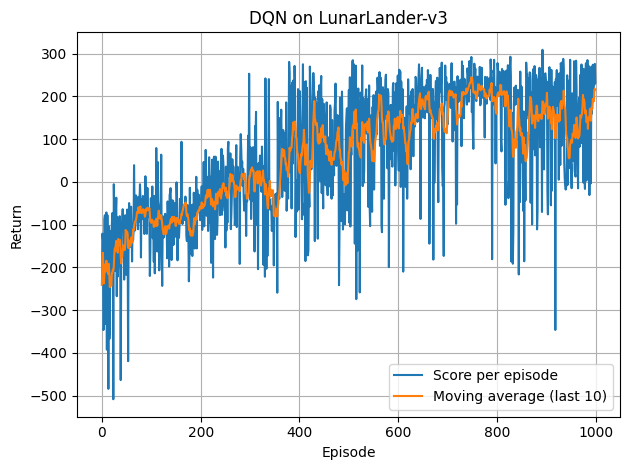

Saved GIF to V4.1-Viktor-Rackov-lunarlander.gif


In [ ]:
# Imports & basic setup

import random
from collections import deque

import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Replay buffer

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states      = np.array(states, dtype=np.float32)
        next_states = np.array(next_states, dtype=np.float32)
        actions     = np.array(actions, dtype=np.int64)
        rewards     = np.array(rewards, dtype=np.float32)
        dones       = np.array(dones, dtype=np.float32)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


# Q-network

class QNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
        )

    def forward(self, x):
        return self.net(x)


# DQN agent

class DQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        gamma=0.99,
        lr=1e-3,
        batch_size=64,
        buffer_capacity=100_000,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.995,
        target_update_every=10,
        device=None,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_every = target_update_every

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        self.replay_buffer = ReplayBuffer(buffer_capacity)
        self.train_steps = 0

    def select_action(self, state, explore=True):
        if explore and random.random() < self.epsilon:
            return random.randrange(self.action_dim)

        state_t = torch.as_tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(state_t)
            action = int(torch.argmax(q_values, dim=1).item())
        return action

    def update(self):
        # wait a bit before learning so buffer has diverse data
        if len(self.replay_buffer) < max(self.batch_size, 1000):
            return None

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        states_t      = torch.as_tensor(states, dtype=torch.float32, device=self.device)
        next_states_t = torch.as_tensor(next_states, dtype=torch.float32, device=self.device)
        actions_t     = torch.as_tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards_t     = torch.as_tensor(rewards, dtype=torch.float32, device=self.device)
        dones_t       = torch.as_tensor(dones, dtype=torch.float32, device=self.device)

        # Q(s,a)
        q_values = self.q_net(states_t).gather(1, actions_t).squeeze(1)

        # max_a' Q_target(s', a')
        with torch.no_grad():
            next_q_values = self.target_net(next_states_t).max(dim=1)[0]
            target_q = rewards_t + self.gamma * next_q_values * (1.0 - dones_t)

        loss = nn.MSELoss()(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1.0)
        self.optimizer.step()

        self.train_steps += 1
        if self.train_steps % self.target_update_every == 0:
            self.update_target_net()

        # self.decay_epsilon()

        return float(loss.item())

    def update_target_net(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


# Training loop

def train_dqn(
    num_episodes=500,
    max_steps_per_episode=1000,
    env_name="LunarLander-v3",
    solved_score=250.0,
    print_every=10,
):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        gamma=0.99,
        lr=5e-4,
        batch_size=64,
        buffer_capacity=100_000,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.990,
        target_update_every=10,
        device=device,
    )

    scores = []
    moving_avgs = []

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        total_reward = 0.0

        for t in range(max_steps_per_episode):
            action = agent.select_action(state, explore=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.replay_buffer.push(state, action, reward, next_state, done)
            loss = agent.update()

            state = next_state
            total_reward += reward

            if done:
                break

        scores.append(total_reward)
        moving_avg = np.mean(scores[-10:])
        moving_avgs.append(moving_avg)

        agent.decay_epsilon()

        if episode % print_every == 0:
            print(
                f"Episode {episode:4d} | "
                f"Score: {total_reward:8.2f} | "
                f"Avg(10): {moving_avg:8.2f} | "
                f"Epsilon: {agent.epsilon:.3f}"
            )

        if moving_avg >= solved_score and episode >= 10:
            print(f"Solved environment in {episode} episodes! Moving average score = {moving_avg:.2f}")
            break

    env.close()

    # Plot learning curve
    plt.figure()
    plt.plot(scores, label="Score per episode")
    plt.plot(moving_avgs, label="Moving average (last 10)")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("DQN on LunarLander-v3")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("dqn_lunarlander_scores.png", dpi=150)
    plt.show()

    return agent, scores, moving_avgs


# Make GIF

def make_gif(
    agent: DQNAgent,
    filename="dqn_lunarlander.gif",
    env_name="LunarLander-v3",
    episodes=1,
    max_steps_per_episode=1000,
    fps=30,
):
    env = gym.make(env_name, render_mode="rgb_array")
    frames = []

    for ep in range(episodes):
        state, _ = env.reset()
        for t in range(max_steps_per_episode):
            action = agent.select_action(state, explore=False)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            frame = env.render()
            frames.append(frame)

            state = next_state
            if done:
                break

    env.close()

    imageio.mimsave(filename, frames, fps=fps)
    print(f"Saved GIF to {filename}")


# === Run training and GIF generation ===

agent, scores, moving_avgs = train_dqn(
    num_episodes=1500,
    max_steps_per_episode=1000,
    env_name="LunarLander-v3",
    solved_score=400.0,
    print_every=10,
)

make_gif(
    agent,
    filename="V4.1-Viktor-Rackov-lunarlander.gif",
    env_name="LunarLander-v3",
    episodes=1,
    max_steps_per_episode=1000,
    fps=30,
)
